In [11]:
%cd /users/anglos/Developer/psiphi

/auto/users/anglos/Developer/psiphi


In [12]:
#@title Imports
import jax
import tree

import social_rl

In [13]:
#@title Constants, experiment config.
GOAL_COLOR = 'red'
NUM_LEARNING_STEPS = 5_000
BATCH_SIZE = 64
DATA_DIR = 'data'
EXPERT_EPSILON = 0.1

In [14]:
#@title Collect expert data: Run this only once!
if False:
  %run experiments/collect_rollouts.py \
    --config=experiments/configs/collect_rollouts.py:{GOAL_COLOR} \
    --config.num_rollouts=500 \
    --config.epsilon={EXPERT_EPSILON}
  from absl import logging
  logging.set_verbosity(logging.ERROR)

In [15]:
#@title Initialise environment, agent and offline dataset.
env = social_rl.GridWorld(goal_color=GOAL_COLOR)
replay_buffer = social_rl.replay.DemonstrationsBuffer(
    batch_size=BATCH_SIZE,
    data_dir='{}/{}/{}'.format(DATA_DIR, GOAL_COLOR, EXPERT_EPSILON),
    seed=42)
for evaluation in (True, False):
  assert replay_buffer.can_sample(evaluation)
agent = social_rl.agents.BCAgent(env)

100%|██████████| 600/600 [00:01<00:00, 579.31it/s]


100%|██████████| 5000/5000 [00:09<00:00, 527.05it/s]


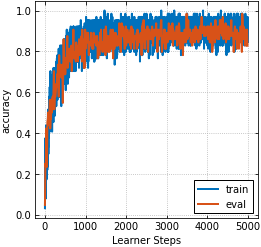

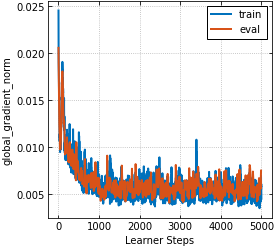

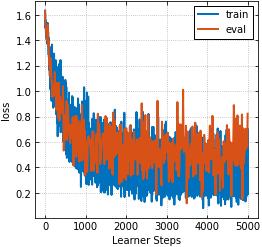

In [16]:
#@title Train agent on offline dataset.
learner_buffer_loop = social_rl.loops.LearnerBufferLoop(replay_buffer, agent)
rng_key = jax.random.PRNGKey(42)
rng_key, learner_key = jax.random.split(rng_key, num=2)
params, learner_state, learner_stats = learner_buffer_loop.run(
    learner_key, num_iterations=NUM_LEARNING_STEPS, evaluate_every=10)
social_rl.plotting.plot_learner_buffer_loop_stats(learner_stats);

In [20]:
#@title Evaluate agent online.
def evaluate(env: social_rl.GridWorld) -> float:
  """Return the success rate on `env`."""
  actor_env_loop = social_rl.loops.ActorEnvironmentLoop(env, agent)
  _, actor_stats = actor_env_loop.run(
    jax.random.PRNGKey(42), num_iterations=500, params=params, evaluation=False)
  return actor_stats['returns'].sum() / len(actor_stats['returns'])

environments = {
    goal_color: social_rl.GridWorld(goal_color=goal_color, seed=42)
    for goal_color in ('red', 'green', 'blue')
}
tree.map_structure(evaluate, environments)

100%|██████████| 500/500 [00:01<00:00, 321.52it/s]


{'red': 0.412, 'green': -0.418, 'blue': -0.476}